In [4]:
from pynq import Overlay

# Laad je bitstream
overlay = Overlay("design_1_wrapper.bit")

# Toon alle IP cores die in de overlay zitten
print(overlay.ip_dict.keys())

dict_keys(['image_pooling_0', 'processing_system7_0'])


In [6]:
from pprint import pprint
pprint(pool_ip.register_map)


RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  src_1 = Register(src=write-only),
  src_2 = Register(src=write-only),
  dst_min_1 = Register(dst_min=write-only),
  dst_min_2 = Register(dst_min=write-only),
  dst_max_1 = Register(dst_max=write-only),
  dst_max_2 = Register(dst_max=write-only)
}


🔄 Processing foto0.png ...


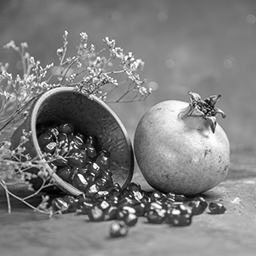

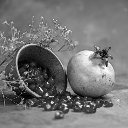

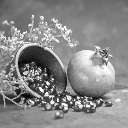

🔄 Processing foto1.png ...


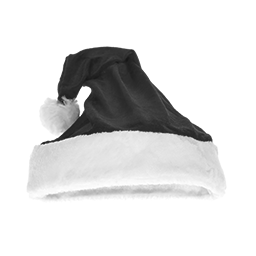

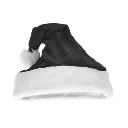

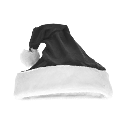

🔄 Processing foto2.png ...


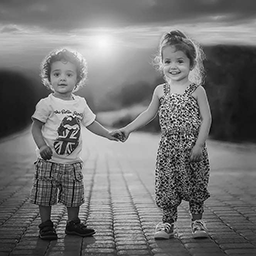

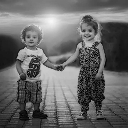

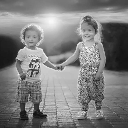

🔄 Processing foto3.png ...


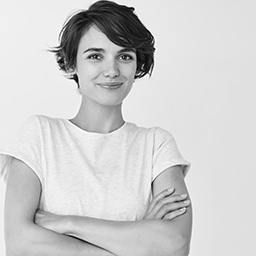

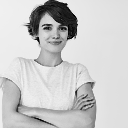

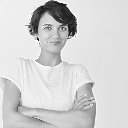

🔄 Processing foto4.png ...


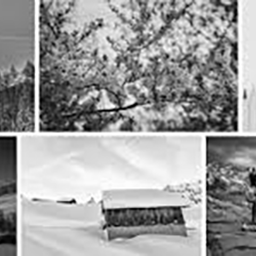

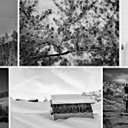

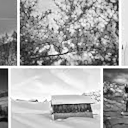

🔄 Processing foto5.png ...


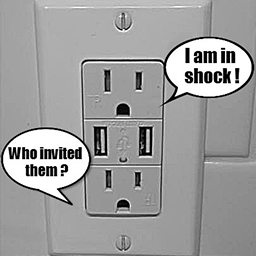

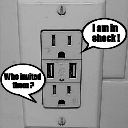

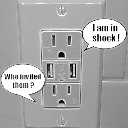

🔄 Processing foto6.png ...


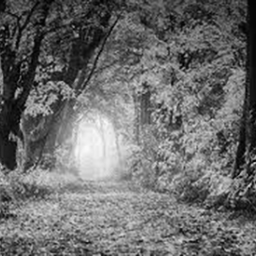

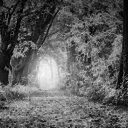

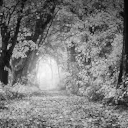

🔄 Processing foto7.png ...


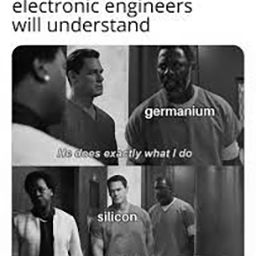

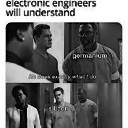

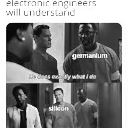

🔄 Processing foto8.png ...


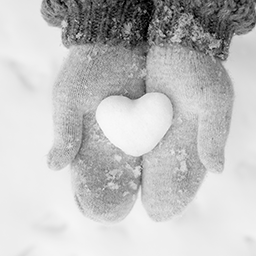

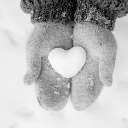

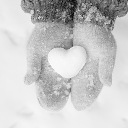

🔄 Processing foto9.png ...


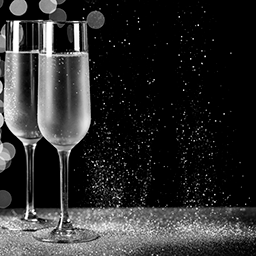

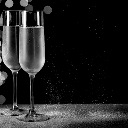

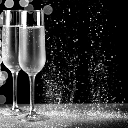

In [11]:
from pynq import Overlay
from pynq import allocate
from PIL import Image
import numpy as np
import os
import time

from IPython.display import display, HTML

# Load bitstream with pooling IP
overlay = Overlay("design_1_wrapper.bit")
pool_ip = overlay.image_pooling_0  # Pas aan indien nodig

# Directories
input_dir = "/home/xilinx/jupyter_notebooks/pictures_input"
output_dir = "/home/xilinx/jupyter_notebooks/pooling_outputs"
os.makedirs(output_dir, exist_ok=True)

# Constants
IMG_HEIGHT = 256
IMG_WIDTH = 256
OUT_HEIGHT = IMG_HEIGHT // 2
OUT_WIDTH = IMG_WIDTH // 2

# Helper to write 64-bit address to 2x32-bit registers
def write_addr(ip, reg_low, reg_high, addr):
    setattr(ip.register_map, reg_low, addr & 0xFFFFFFFF)
    setattr(ip.register_map, reg_high, (addr >> 32) & 0xFFFFFFFF)

# Process max 10 images
image_list = sorted([
    f for f in os.listdir(input_dir)
    if f.lower().endswith((".png", ".jpg", ".bmp"))
])[:10]

for img_name in image_list:
    img_path = os.path.join(input_dir, img_name)
    print(f"🔄 Processing {img_name} ...")

    # Load and convert to grayscale
    img = Image.open(img_path).convert("L").resize((IMG_WIDTH, IMG_HEIGHT))
    img_array = np.array(img, dtype=np.uint8)

    # Allocate buffers
    in_buffer = allocate(shape=(IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
    out_min_buffer = allocate(shape=(OUT_HEIGHT, OUT_WIDTH), dtype=np.uint8)
    out_max_buffer = allocate(shape=(OUT_HEIGHT, OUT_WIDTH), dtype=np.uint8)

    np.copyto(in_buffer, img_array)

    # Write buffer addresses

    write_addr(pool_ip, "src_1", "src_2", in_buffer.physical_address)
    write_addr(pool_ip, "dst_min_1", "dst_min_2", out_min_buffer.physical_address)
    write_addr(pool_ip, "dst_max_1", "dst_max_2", out_max_buffer.physical_address)

    # Start pooling
    start_time = time.time()
    pool_ip.register_map.CTRL.AP_START = 1
    while not pool_ip.register_map.CTRL.AP_DONE:
        pass
    elapsed = time.time() - start_time

    # Save results
    out_min_path = os.path.join(output_dir, f"min_{img_name}")
    out_max_path = os.path.join(output_dir, f"max_{img_name}")

    Image.fromarray(out_min_buffer).save(out_min_path)
    Image.fromarray(out_max_buffer).save(out_max_path)

    # Display input and outputs
    display(HTML(f"<h4>{img_name} (⏱ {elapsed:.4f} sec)</h4>"))
    display(HTML("<b>Input Image</b>"))
    display(img)

    display(HTML("<b>Min Pooling Result</b>"))
    display(Image.open(out_min_path))

    display(HTML("<b>Max Pooling Result</b>"))
    display(Image.open(out_max_path))

    # Free buffers
    in_buffer.freebuffer()
    out_min_buffer.freebuffer()
    out_max_buffer.freebuffer()


🔄 Processing foto0.png ...
🟡 Sample output min pool: [[72 74 76 79]
 [72 76 80 81]
 [74 79 82 85]
 [77 81 83 88]]
🟣 Sample output max pool: [[73 77 79 81]
 [74 79 82 85]
 [79 82 84 88]
 [79 83 89 92]]
   ➕ Max in max_buffer: 255
   ➖ Min in max_buffer: 0


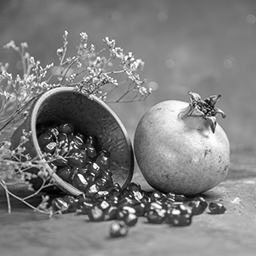

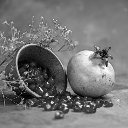

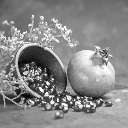

🔄 Processing foto1.png ...
🟡 Sample output min pool: [[255 255 255 255]
 [255 255 255 255]
 [255 255 255 255]
 [255 255 255 255]]
🟣 Sample output max pool: [[255 255 255 255]
 [255 255 255 255]
 [255 255 255 255]
 [255 255 255 255]]
   ➕ Max in max_buffer: 255
   ➖ Min in max_buffer: 28


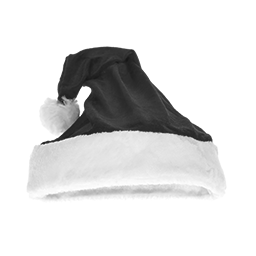

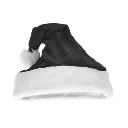

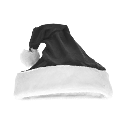

🔄 Processing foto2.png ...
🟡 Sample output min pool: [[ 82  82  85  86]
 [ 87  86  87  89]
 [ 96  94  94  94]
 [102 100 100  98]]
🟣 Sample output max pool: [[ 84  84  87  87]
 [ 92  92  92  92]
 [101  99  98  98]
 [105 105 103 101]]
   ➕ Max in max_buffer: 250
   ➖ Min in max_buffer: 12


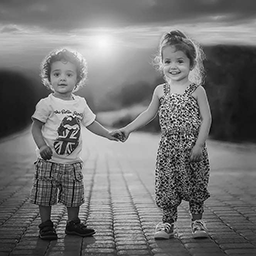

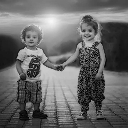

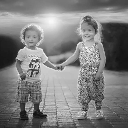

🔄 Processing foto3.png ...
🟡 Sample output min pool: [[239 239 239 239]
 [239 239 239 239]
 [239 239 239 239]
 [239 239 239 239]]
🟣 Sample output max pool: [[239 239 239 239]
 [239 239 239 239]
 [239 239 239 239]
 [240 239 240 239]]
   ➕ Max in max_buffer: 255
   ➖ Min in max_buffer: 8


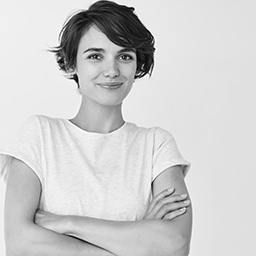

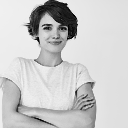

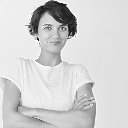

🔄 Processing foto4.png ...
🟡 Sample output min pool: [[135 134 134 134]
 [135 134 134 134]
 [135 134 134 134]
 [136 135 135 135]]
🟣 Sample output max pool: [[136 135 134 134]
 [136 135 134 134]
 [136 135 134 134]
 [136 136 135 135]]
   ➕ Max in max_buffer: 255
   ➖ Min in max_buffer: 1


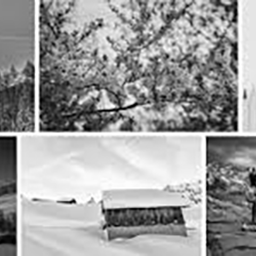

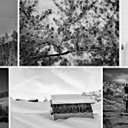

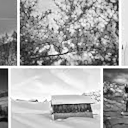

🔄 Processing foto5.png ...
🟡 Sample output min pool: [[156 162 158 162]
 [159 158 161 161]
 [160 160 162 162]
 [160 160 162 162]]
🟣 Sample output max pool: [[157 164 162 162]
 [160 161 162 162]
 [161 161 163 162]
 [160 161 162 162]]
   ➕ Max in max_buffer: 255
   ➖ Min in max_buffer: 0


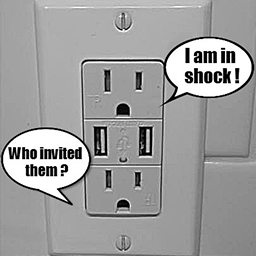

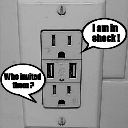

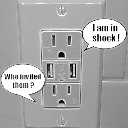

🔄 Processing foto6.png ...
🟡 Sample output min pool: [[ 7  7 24 53]
 [ 8 12  8 62]
 [14  8  5 33]
 [20 21 11 31]]
🟣 Sample output max pool: [[ 8 21 39 73]
 [13 26 31 83]
 [24 23 29 65]
 [25 26 21 59]]
   ➕ Max in max_buffer: 250
   ➖ Min in max_buffer: 5


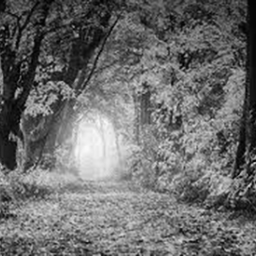

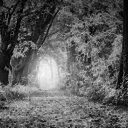

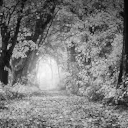

🔄 Processing foto7.png ...
🟡 Sample output min pool: [[255 255 255 255]
 [255 255 255 255]
 [255 255 255 255]
 [255 255 255 255]]
🟣 Sample output max pool: [[255 255 255 255]
 [255 255 255 255]
 [255 255 255 255]
 [255 255 255 255]]
   ➕ Max in max_buffer: 255
   ➖ Min in max_buffer: 3


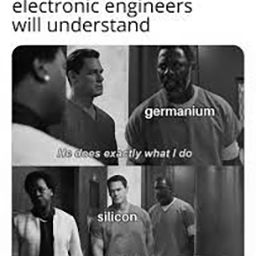

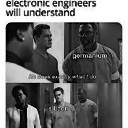

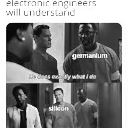

🔄 Processing foto8.png ...
🟡 Sample output min pool: [[234 234 233 233]
 [234 234 233 233]
 [234 234 234 233]
 [235 234 234 234]]
🟣 Sample output max pool: [[234 234 234 233]
 [235 234 234 233]
 [235 234 234 234]
 [235 235 235 234]]
   ➕ Max in max_buffer: 253
   ➖ Min in max_buffer: 3


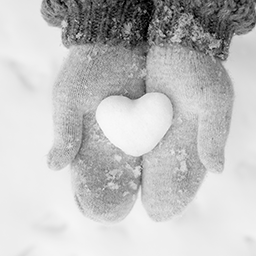

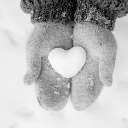

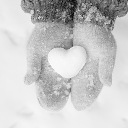

🔄 Processing foto9.png ...
🟡 Sample output min pool: [[65 41  0  0]
 [63  6  0  0]
 [63  0  0  0]
 [ 1  0  0  0]]
🟣 Sample output max pool: [[67 88  0  0]
 [69 88  0  0]
 [90 63  0  0]
 [85  0  0  0]]
   ➕ Max in max_buffer: 255
   ➖ Min in max_buffer: 0


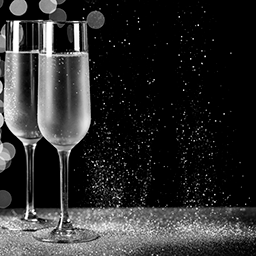

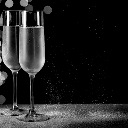

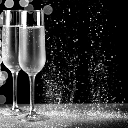

In [9]:
from pynq import Overlay
from pynq import allocate
from PIL import Image
import numpy as np
import os
import time

from IPython.display import display, HTML

# Load bitstream with pooling IP
overlay = Overlay("design_1_wrapper.bit")
pool_ip = overlay.image_pooling_0 

# Directories
input_dir = "/home/xilinx/jupyter_notebooks/pictures_input"
output_dir = "/home/xilinx/jupyter_notebooks/pooling_outputs"
os.makedirs(output_dir, exist_ok=True)

# Constants
IMG_HEIGHT = 256
IMG_WIDTH = 256
OUT_HEIGHT = IMG_HEIGHT // 2
OUT_WIDTH = IMG_WIDTH // 2

# Helper to write 64-bit address to 2x32-bit registers
def write_addr(ip, reg_low, reg_high, addr):
    setattr(ip.register_map, reg_low, addr & 0xFFFFFFFF)
    setattr(ip.register_map, reg_high, (addr >> 32) & 0xFFFFFFFF)

# Process max 10 images
image_list = sorted([
    f for f in os.listdir(input_dir)
    if f.lower().endswith((".png", ".jpg", ".bmp"))
])[:10]

for img_name in image_list:
    img_path = os.path.join(input_dir, img_name)
    print(f"🔄 Processing {img_name} ...")

    # Load and convert to grayscale
    img = Image.open(img_path).convert("L").resize((IMG_WIDTH, IMG_HEIGHT))
    img_array = np.array(img, dtype=np.uint8)

    # Allocate buffers
    in_buffer = allocate(shape=(IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
    out_min_buffer = allocate(shape=(OUT_HEIGHT, OUT_WIDTH), dtype=np.uint8)
    out_max_buffer = allocate(shape=(OUT_HEIGHT, OUT_WIDTH), dtype=np.uint8)

    np.copyto(in_buffer, img_array)

    # Correct register names
    write_addr(pool_ip, "src_1", "src_2", in_buffer.physical_address)
    write_addr(pool_ip, "dst_min_1", "dst_min_2", out_min_buffer.physical_address)
    write_addr(pool_ip, "dst_max_1", "dst_max_2", out_max_buffer.physical_address)

    # Start pooling
    start_time = time.time()
    pool_ip.register_map.CTRL.AP_START = 1

    # Wait until done with timeout
    timeout = 2.0
    while not pool_ip.register_map.CTRL.AP_DONE:
        if time.time() - start_time > timeout:
            print("⚠️ Timeout: IP lijkt vast te zitten.")
            break

    elapsed = time.time() - start_time

    # Debug: Toon waarden uit buffers
    print("🟡 Sample output min pool:", out_min_buffer[:4, :4])
    print("🟣 Sample output max pool:", out_max_buffer[:4, :4])

    print("   ➕ Max in max_buffer:", np.max(out_max_buffer))
    print("   ➖ Min in max_buffer:", np.min(out_max_buffer))

    # Save results
    out_min_path = os.path.join(output_dir, f"min_{img_name}")
    out_max_path = os.path.join(output_dir, f"max_{img_name}")

    Image.fromarray(out_min_buffer).save(out_min_path)
    Image.fromarray(out_max_buffer).save(out_max_path)

    # Display input and outputs
    display(HTML(f"<h4>{img_name} (⏱ {elapsed:.4f} sec)</h4>"))
    display(HTML("<b>Input Image</b>"))
    display(img)

    display(HTML("<b>Min Pooling Result</b>"))
    display(Image.open(out_min_path))

    display(HTML("<b>Max Pooling Result</b>"))
    display(Image.open(out_max_path))

    # Free buffers
    in_buffer.freebuffer()
    out_min_buffer.freebuffer()
    out_max_buffer.freebuffer()
